In [3]:
!pip install torch

Keyring is skipped due to an exception: 'keyring.backends'


In [4]:
!pip install torchvision

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached torchvision-0.14.0-cp37-cp37m-manylinux1_x86_64.whl (24.3 MB)


In [50]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import random
import os
import enum
import numpy as np

In [51]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 2021
seed_torch(seed)

In [52]:
train_data = datasets.CIFAR10('./data', #データを保存するdir
                              train = True,  #True : 学習用データ False : テストデータ 
                              download=True,  # downloadするか否か
                              transform = T.Compose([T.ToTensor()]) #前処理の設定
                              )
train_loader = DataLoader(train_data,batch_size=128)

Files already downloaded and verified


In [53]:
transforms = T.Compose([T.Resize(256),
                        T.CenterCrop(224),
                        ])

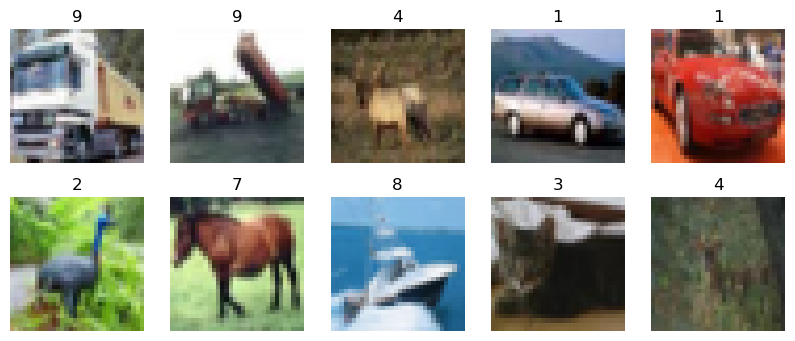

In [54]:
for i in train_loader:
    data = i[0]
    label = i[1]
    break

fig = plt.figure(figsize = (10,4))
for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    ax.axis("off")
    ax.set_title(label[i].numpy())
    ax.imshow(data[i].permute(1,2,0))
plt.show()

In [55]:
class QuestionType(enum.Enum):
    WHICH_ONE = 'which_one'
    IS_IN = 'is_in'
class DataSet(enum.Enum):
    MNIST = 'mnist'
    CIFAR10 = 'cifar10'
    CIFAR100 = 'cifar100'


In [166]:
def generate_cifar10_dataloader(batch_size):
    train_transform = T.Compose(
        [T.ToTensor(), # transforms.RandomHorizontalFlip(), transforms.RandomCrop(32,4),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    test_transform = T.Compose(
        [T.ToTensor(),
         T.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    full_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=len(train_dataset.data), shuffle=False, num_workers=0)
    return full_train_loader, train_loader, test_loader, train_dataset, test_dataset
full_train_loader, train_loader, test_loader, train_dataset, test_dataset = generate_cifar10_dataloader(256)
datas, labels = next(iter(full_train_loader))

Files already downloaded and verified


In [167]:
def generate_Q_A_label(
    single_class_assigned: int, 
    question_type: int, 
    all_class_size: int, 
    question_class_size: int) -> list:
    
    all_class_set = range(all_class_size)
    question_class_set = random.sample(all_class_set, question_class_size)
    temporary_label_list = [0 for i in range(all_class_size)]
    
    if question_type == QuestionType.WHICH_ONE:
        if single_class_assigned in question_class_set:
            for i in [single_class_assigned]:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
        
    elif question_type == QuestionType.IS_IN:
        if single_class_assigned in question_class_set:
            for i in question_class_set:
                temporary_label_list[i] = 1
        
        else:
            comp_question_class_set = [i for i in all_class_set if i not in question_class_set]
            for i in comp_question_class_set:
                temporary_label_list[i] = 1
    
    return temporary_label_list

temporary_label_list = generate_Q_A_label(single_class_assigned=6, 
                                          question_type=QuestionType.WHICH_ONE, 
                                          all_class_size=10, 
                                          question_class_size=9)

temporary_label_list


[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [168]:
def generate_Q_A_labels(labels_tensor: torch.tensor, 
                        question_type: QuestionType,
                        all_class_size: int,
                        question_class_size: int) -> torch.tensor:
    
    labels_list = labels_tensor.tolist()
    Q_A_labels_list = []
    
    for label in labels_list:
        Q_A_label = generate_Q_A_label(single_class_assigned=label, 
                                       question_type=question_type,  # change out of this function
                                       all_class_size=all_class_size, # change out of this function
                                       question_class_size=question_class_size) # change out of this function
        Q_A_labels_list.append(Q_A_label)
        
    Q_A_labels_tensor = torch.tensor(Q_A_labels_list)
    
    return Q_A_labels_tensor

In [169]:
def generate_cifar10_dataloader_with_Q_A_label(full_train_loader: DataLoader, 
                                               question_type: QuestionType,
                                               question_size: int,
                                               batch_size: int) ->[DataLoader, int]:
    
    for i, (datas, labels) in enumerate(full_train_loader):
        all_class_size = torch.max(labels) + 1 # K is number of classes, full_train_loader is full batch
        
    Q_A_labels_tensor = generate_Q_A_labels(labels, question_type, all_class_size, question_size)
    Q_A_labels_matrix_dataset = torch.utils.data.TensorDataset(datas, Q_A_labels_tensor.float())
    Q_A_labels_matrix_train_loader = torch.utils.data.DataLoader(dataset=Q_A_labels_matrix_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    dimension = int(datas.reshape(-1).shape[0]/datas.shape[0])
    return Q_A_labels_matrix_train_loader, dimension, all_class_size.tolist()

Q_A_labels_matrix_train_loader, dimension, all_class_size = generate_cifar10_dataloader_with_Q_A_label(full_train_loader, 
                                                                                                      QuestionType.WHICH_ONE,
                                                                                                      question_size=9,
                                                                                                      batch_size=256)
Q_A_datas, Q_A_labels = next(iter(Q_A_labels_matrix_train_loader))
print(Q_A_datas)
print(Q_A_labels)
print(dimension)
print(all_class_size)

tensor([[[[ 1.5193e+00,  1.3764e+00,  1.4717e+00,  ...,  1.7098e+00,
            1.7892e+00,  1.8051e+00],
          [ 1.6781e+00,  1.4717e+00,  1.5193e+00,  ...,  1.7575e+00,
            1.8051e+00,  1.8527e+00],
          [ 1.8210e+00,  1.5193e+00,  1.4875e+00,  ...,  1.6146e+00,
            1.6146e+00,  1.6146e+00],
          ...,
          [-6.0819e-01, -1.1480e+00, -1.4020e+00,  ..., -7.1933e-01,
           -7.3521e-01, -6.0819e-01],
          [-5.6056e-01, -7.8284e-01, -1.1004e+00,  ..., -6.3995e-01,
           -6.2407e-01, -6.0819e-01],
          [-7.5108e-01, -8.6222e-01, -1.1798e+00,  ..., -5.4469e-01,
           -5.7644e-01, -5.9232e-01]],

         [[ 1.7113e+00,  1.5499e+00,  1.6790e+00,  ...,  1.8727e+00,
            1.9533e+00,  1.9856e+00],
          [ 1.8727e+00,  1.6467e+00,  1.7113e+00,  ...,  1.9533e+00,
            2.0018e+00,  2.0340e+00],
          [ 2.0179e+00,  1.6951e+00,  1.6629e+00,  ...,  1.8242e+00,
            1.8242e+00,  1.8404e+00],
          ...,
     

In [170]:
# Unclear!!!
DataSet_2_DataLoader_generator = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}
DataSet_2_DataLoader_generator_with_Q_A_label = {
    #DataSet.MNIST: generate_mnist_dataloader,
    DataSet.CIFAR10: generate_cifar10_dataloader_with_Q_A_label,
    #DataSet.CIFAR100: generate_cifar100_dataloader,
}

def DataSet_2_DataLoader_with_Q_A_label(dataset: DataSet,
                                        question_type: QuestionType,
                                        question_size: int,
                                        batch_size: int
                                        ) -> [DataLoader, DataLoader, DataLoader]:
    
    dataloader_generator = DataSet_2_DataLoader_generator[dataset]
    full_train_loader, train_loader, test_loader, train_dataset, test_dataset = dataloader_generator(batch_size)
    dataloader_generator_with_Q_A_label = DataSet_2_DataLoader_generator_with_Q_A_label[dataset]
    Q_A_labels_matrix_train_loader, dimension, all_class_size = dataloader_generator_with_Q_A_label(full_train_loader, question_type, question_size, batch_size)
    
    return Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size

DataSet_2_DataLoader_with_Q_A_label(DataSet.CIFAR10, QuestionType.WHICH_ONE, 9, 256)

Files already downloaded and verified


(<torch.utils.data.dataloader.DataLoader at 0x7fb9ac75cdd0>,
 3072,
 10)

In [186]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def mae_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.L1Loss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss
    
def mse_loss(outputs, labels):
    sm_outputs = F.softmax(outputs, dim=1)
    loss_fn = nn.MSELoss(reduction='none')
    loss_matrix = loss_fn(sm_outputs, labels.float())
    sample_loss = loss_matrix.sum(dim=-1)
    return sample_loss

def gce_loss(outputs, labels):
    q = 0.7
    sm_outputs = F.softmax(outputs, dim=1)
    pow_outputs = torch.pow(sm_outputs, q)
    sample_loss = (1-(pow_outputs*labels).sum(dim=1))/q # n
    return sample_loss

def phuber_ce_loss(outputs, labels):
    trunc_point = 0.1
    n = labels.shape[0]
    soft_max = nn.Softmax(dim=1)
    sm_outputs = soft_max(outputs)
    final_outputs = sm_outputs * labels
    final_confidence = final_outputs.sum(dim=1)
   
    ce_index = (final_confidence > trunc_point)
    sample_loss = torch.zeros(n).to(device)

    if ce_index.sum() > 0:
        ce_outputs = outputs[ce_index,:]
        logsm = nn.LogSoftmax(dim=-1)
        logsm_outputs = logsm(ce_outputs)
        final_ce_outputs = logsm_outputs * labels[ce_index,:]
        sample_loss[ce_index] = - final_ce_outputs.sum(dim=-1)

    linear_index = (final_confidence <= trunc_point)

    if linear_index.sum() > 0:
        sample_loss[linear_index] = -math.log(trunc_point) + (-1/trunc_point)*final_confidence[linear_index] + 1

    return sample_loss

def ce_loss(outputs, labels):
    logsm = nn.LogSoftmax(dim=1)
    logsm_outputs = logsm(outputs)
    final_outputs = logsm_outputs * labels
    sample_loss = - final_outputs.sum(dim=1)
    return sample_loss

def W_O_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = loss_fn(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - ((all_class_size - question_class_size) * (all_class_size - question_class_size - 1))/(question_class_size * (2*all_class_size - question_class_size - 1.0)) * noncandidate_loss
    average_loss = total_loss.mean()
    return average_loss

def I_I_loss(loss_fn, outputs, labels, device, question_class_size, all_class_size):
    n, k = labels.shape[0], labels.shape[1]
    temp_loss = torch.zeros(n, k).to(device)
    for i in range(k):
        tempY = torch.zeros(n, k).to(device)
        tempY[:, i] = 1.0
        temp_loss[:, i] = ce_loss(outputs, tempY)
        
    candidate_loss = (temp_loss * labels).sum(dim=1)
    noncandidate_loss = (temp_loss * (1-labels)).sum(dim=1)
    total_loss = candidate_loss - (2*question_class_size**2 + all_class_size**2 - all_class_size*(2*question_class_size + 1))/(2*question_class_size * (all_class_size - question_class_size)) * noncandidate_loss
    average_loss = total_loss.mean()
    return average_loss


In [187]:
class mlp_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(mlp_model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = x.view(-1, self.num_flat_features(x))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [188]:
def accuracy_check(loader, model, device):
    with torch.no_grad():
        total, num_samples = 0, 0
        for images, labels in loader:
            labels, images = labels.to(device), images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += (predicted == labels).sum().item()
            num_samples += labels.size(0) 
    return total / num_samples

In [189]:
def show_score(epoch,max_epoch,itr,max_itr,loss,acc,is_val=False):
    print('\r{} EPOCH[{:03}/{:03}] ITR [{:04}/{:04}] LOSS:{:.05f} ACC:{:03f}'.format("VAL  " if is_val else "TRAIN",epoch,max_epoch,itr,max_itr,loss,acc*100),end = '')

In [216]:
def Train_Eval(model, question_type, question_class_size, all_class_size, criterion, optimizer, data_loader, evaluation_data_loader, device, epoch, max_epoch):
        
    total_loss = 0.0
    total_acc = 0.0
    counter = 0

    for n, (data, label) in enumerate(data_loader):
        model.train()
        counter += data.shape[0]
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        #if is_val:
        #    with torch.no_grad():
        #        output = model(data)
        output = model(data)
        if question_type == QuestionType.WHICH_ONE:
            loss = W_O_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        elif question_type == QuestionType.IS_IN:
            loss = I_I_loss(criterion, output, label.float(), device, question_class_size, all_class_size)
        else:
            loss = criterion(output,label)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        model.eval()
        total_acc += accuracy_check(evaluation_data_loader, model, device)
        #total_acc += accuracy_check(evaluation_data_loader, model, device)


        #if is_val != True:
        show_score(epoch+1,max_epoch,n+1,len(data_loader),total_loss/(n+1), total_acc/counter,is_val=is_val)
        print()
    return total_loss , total_acc
        

In [217]:
def Q_A_label_Train_Eval(dataset, question_type, question_class_size, model, batch_size, loss_fn, EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                           question_type, 
                                                                                                                           question_class_size,
                                                                                                                           batch_size)
    model = model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    
    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []
    #criterion=nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        train_loss,train_acc = Train_Eval(model=model, 
                                          question_type=question_type,
                                          question_class_size=question_class_size,
                                          all_class_size=all_class_size,
                                          criterion=loss_fn,
                                          optimizer=optimizer, 
                                          data_loader=Q_A_labels_matrix_train_loader,
                                          evaluation_data_loader=train_loader,
                                          device=DEVICE, 
                                          epoch=epoch, 
                                          max_epoch=EPOCHS)
        #val_loss,val_acc    = Train_Eval(model,criterion,optimizer,test_loader,DEVICE,epoch,EPOCHS,is_val=True)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        #val_loss_list.append(val_loss)
        #val_acc_list.append(val_acc)

In [ ]:
Q_A_label_Train_Eval(DataSet.CIFAR10, QuestionType.WHICH_ONE, 9, mlp_model, 64, ce_loss, 300)

Files already downloaded and verified


In [206]:
def Ord_label_Train_Eval(dataset, model, batch_size, loss_fn, EPOCHS):
    Q_A_labels_matrix_train_loader, train_loader, test_loader, dimension, all_class_size = DataSet_2_DataLoader_with_Q_A_label(dataset, 
                                                                                                                           QuestionType.WHICH_ONE, 
                                                                                                                           5,
                                                                                                                           batch_size)
    model = model(input_dim=dimension, hidden_dim=500, output_dim=all_class_size).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    
    train_loss_list = []
    val_loss_list = []

    train_acc_list = []
    val_acc_list = []
    #criterion=nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        train_loss,train_acc = Train_Eval(model=model, 
                                          question_type=None,
                                          question_class_size=None,
                                          all_class_size=None,
                                          criterion=loss_fn,
                                          optimizer=optimizer, 
                                          data_loader=train_loader,
                                          evaluation_data_loader=train_loader,
                                          device=DEVICE, 
                                          epoch=epoch, 
                                          max_epoch=EPOCHS)
        #val_loss,val_acc    = Train_Eval(model,criterion,optimizer,test_loader,DEVICE,epoch,EPOCHS,is_val=True)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        #val_loss_list.append(val_loss)
        #val_acc_list.append(val_acc)

In [207]:
Ord_label_Train_Eval(DataSet.CIFAR10, mlp_model, 64, nn.CrossEntropyLoss(), 300)

Files already downloaded and verified
TRAIN EPOCH[001/300] ITR [0004/0782] LOSS:2.39609 ACC:0.282781

KeyboardInterrupt: 